<a href="https://colab.research.google.com/github/iamsayan28/ml-paper-implementations/blob/main/gpt-2/gpt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import math

from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from transformers import GPT2Tokenizer

from datasets import load_dataset

import os
import glob

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

### GPT-2 config

In [ ]:
# need to scale down the numbers to be able to train it in colab within reasonable time

config = {
    "vocab_size": 50257,
    "context_length": 512,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}


### Load the data

In [ ]:
from datasets import load_dataset

dataset = load_dataset("roneneldan/TinyStories", split="train[:10%]")
dataset

### Tokenization



Define the tokenizer and tokenize the dataset

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.vocab_size

In [ ]:
def tokenizer_function(dataset):
  output = tokenizer(
      dataset['text'],
      truncation = True,
      max_length = 256,
      padding = "max_length",
      # return_tensors = 'pt' # Remove this
  )

  return output
# dataset has a text col which we tokenize on the text and then remove the col text and in place we have input_ids column created by the tokenizer(from the transformers lib) which
# has all the token ids present
tokenized_dataset = dataset.map(tokenizer_function, batched = True, remove_columns=['text'])

In [ ]:
def create_labels(dataset):
  # dataset['labels'] = dataset['input_ids'].clone() # This was causing the error
  # dataset['labels'] = [tensor.clone() for tensor in dataset['input_ids']] # Previous fix attempt
  # Assuming dataset['input_ids'] is a list of lists of integers from the tokenizer
  input_ids_list = dataset['input_ids']
  # Convert the list of lists to a tensor
  input_ids_tensor = torch.tensor(input_ids_list)
  # Clone the tensor to create labels
  dataset['labels'] = input_ids_tensor.clone()
  return dataset

tokenized_dataset = tokenized_dataset.map(create_labels, batched = True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_dataset

In [ ]:
train_loader = DataLoader(tokenized_dataset, batch_size = 16, shuffle = True)
len(train_loader)

In [ ]:
def analyze_token_distribution(data_loader):
    all_token_counts = []

    for batch in data_loader:
        token_counts = batch['attention_mask'].sum(dim=1)
        all_token_counts.extend(token_counts.tolist())

    all_token_counts = torch.tensor(all_token_counts)

    print(f"Dataset token statistics:")
    print(f"Total sequences: {len(all_token_counts)}")
    print(f"Min tokens: {all_token_counts.min()}")
    print(f"Max tokens: {all_token_counts.max()}")
    print(f"Mean tokens: {all_token_counts.float().mean():.2f}")
    print(f"Median tokens: {all_token_counts.median()}")

    # Show distribution
    import matplotlib.pyplot as plt
    plt.hist(all_token_counts.numpy(), bins=50)
    plt.xlabel('Number of actual tokens')
    plt.ylabel('Frequency')
    plt.title('Distribution of actual token counts')
    plt.show()

analyze_token_distribution(train_loader)

### Input Embedding

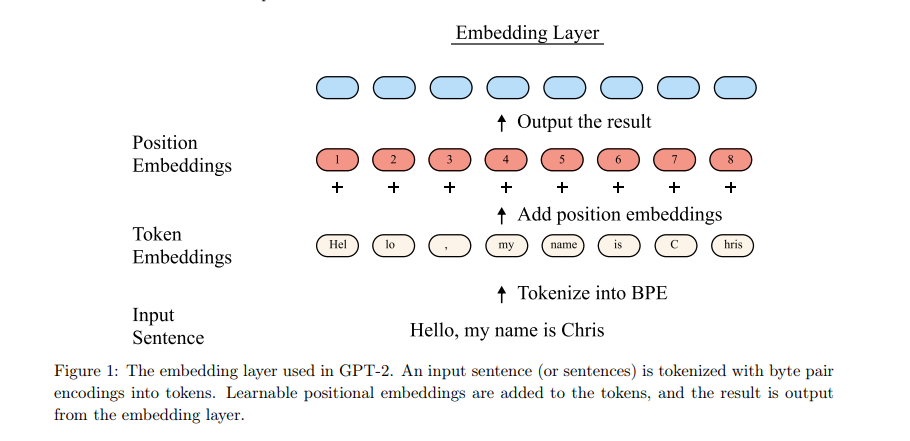

In [ ]:
class Embedding(nn.Module):
  def __init__(self, vocab_size, d_model):
    super().__init__();
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    # x -> (batch size, seq_len), each batch size has seq_len no of token ids
    return self.embedding(x)


embedding = Embedding(config["vocab_size"], config["emb_dim"])
input_ids = torch.randint(0, config["vocab_size"], (2, 256))
print(input_ids.shape)
embedding_output = embedding(input_ids)
print(embedding_output.shape) # -> (batch size, seq_len, d_model)
assert embedding_output.shape == (2, 256, config['emb_dim']), "Embedding shape mismatch"

### Positional Encoding > MHA > LN > FFNN

In [ ]:
class PositionalEmbedding(nn.Module):
  def __init__(self, seq_len, d_model):
    super().__init__()
    # pe = nn.Embedding(seq_len, d_model)

    pe = torch.zeros(seq_len, d_model)
    pos = torch.arange(0, seq_len).unsqueeze(1) # (seq_len,) -> (seq_len, 1)
    denom = torch.exp(torch.arange(0,d_model,2) * (math.log(10000)/d_model)).unsqueeze(0)  # (d_model/2,) -> (1, d_model/2)
    pe[:,0::2] = torch.sin(pos * denom)
    pe[:,1::2] = torch.cos(pos * denom)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)

    # problem resolved: was doing pe = torch.zeros(seq_len, d_model).unsqueeze(0) before which resulted (1,seq_len,d_model), and later doing (pos * denom) operation resulted in (seq_len, d_model),
    # removing unsqueeze(0) from pe solved the issue. pe[:,0::2] has a different shape from the situation like (1,seq,d_model) which has 3 dims. Also writing pe.unsqueeze(0) is diff from pe = pe.unsqueeze(0).

  def forward(self, x):
    # x -> (batch, seq_len, d_model)
    # pe -> (1, seq_len, d_model)
    # return x + self.pe (error!)
    # -> The error occurs because the fixed-size positional embedding tensor is being added to an input tensor that has a different sequence length. To fix this, we need to modify
    # the PositionalEmbedding layer so that it can dynamically select the correct portion of the pre-computed positional encoding to match the current input sequence length.

    return x + self.pe[:, :x.size(1), :]

pe = PositionalEmbedding(config["context_length"], config['emb_dim'])
pe_output = pe(embedding_output)
assert pe_output.shape == embedding_output.shape, "Positional Encoding shape mismatch"
print(pe_output.shape)

In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self, d_model, num_heads, qkv_bias = False):
    super().__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads

    self.query = nn.Linear(d_model, d_model, qkv_bias)
    self.key = nn.Linear(d_model, d_model, qkv_bias)
    self.value = nn.Linear(d_model, d_model, qkv_bias)
    self.out = nn.Linear(d_model, d_model, qkv_bias)

  def forward(self, x, mask = None):
    # x -> (batch size, seq len, d_model)
    q = self.query(x).view(x.shape[0], x.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
    k = self.key(x).view(x.shape[0], x.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
    v = self.value(x).view(x.shape[0], x.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
    # q,k,v = (batch, num_heads, seq, head_dim)


    attention_scores = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.head_dim)
    # attention_scores -> (batch, num_heads, seq_len, seq_len)

    if mask is not None:
      attention_scores = attention_scores.masked_fill(mask == 0, 1e-9)
    attention_scores.softmax(dim = -1)
    attention = torch.matmul(attention_scores, v) # (batch, num_heads, seq_len, seq_len).(batch, num_heads, seq_len, head_dim) = (batch, num_heads, seq_len, head_dim)

    final_form = attention.transpose(2,1).contiguous().view(x.shape[0], x.shape[1], -1)

    return self.out(final_form)

mha = MultiHeadAttention(config['emb_dim'], config['n_heads'])
mha_output = mha(pe_output)
assert mha_output.shape == pe_output.shape, print("Shape mismatch")
print(mha_output.shape)

In [ ]:
class LayerNormalization(nn.Module):

  def __init__(self, d_model, eps = 1e-5):
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(d_model))
    self.beta = nn.Parameter(torch.zeros(d_model))

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    std = x.std(dim = -1, keepdim = True, unbiased=False)
    norm_x = (x - mean)/(std + self.eps)
    return self.alpha * norm_x + self.beta

layernorm = LayerNormalization(config['emb_dim'])
layernorm_output = layernorm(mha_output)
assert layernorm_output.shape == mha_output.shape, print("Shape mismatch boi, time to fix this shit")
print(layernorm_output.shape)

In [ ]:
class FeedForwardNetwork(nn.Module):

  def __init__(self, d_model, ffnn_hidden_size):
    super().__init__()
    self.ffnn1 = nn.Linear(d_model, ffnn_hidden_size)
    self.ffnn2 = nn.Linear(ffnn_hidden_size, d_model)
    self.act = nn.GELU()

  def forward(self, x):
    return self.ffnn2(self.act(self.ffnn1(x)))

hidden_size = config['emb_dim'] * 4
ffnn = FeedForwardNetwork(config['emb_dim'], hidden_size)
ffnn_output = ffnn(layernorm_output)
assert layernorm_output.shape == ffnn_output.shape, print("Shape mismatch boi, time to fix this shit")
print(ffnn_output.shape)

### Transformer Block

In [ ]:
class TransformerBlock(nn.Module):

  def __init__(self, d_model, num_heads, ff_hidden_size, dropout = 0.1, qkv_bias = False):
    super().__init__()
    self.mha = MultiHeadAttention(d_model, num_heads, qkv_bias)
    self.ln1 = LayerNormalization(d_model)
    self.ln2 = LayerNormalization(d_model)
    self.ffnn = FeedForwardNetwork(d_model, ff_hidden_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask = None):
    # x as the output of the pe
    mha_output = x + self.dropout(self.mha(self.ln1(x)))
    ffnn_output = mha_output + self.dropout(self.ffnn(self.ln2(mha_output)))
    return ffnn_output

transformer = TransformerBlock(config['emb_dim'], config['n_heads'], hidden_size)
transformer_output = transformer(pe_output)
assert transformer_output.shape == pe_output.shape, print("Shape mismatch")
print(transformer_output.shape)

In [ ]:
class GPT_2(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.input_embedding = Embedding(config["vocab_size"], config["emb_dim"])
    self.pos_embedding = PositionalEmbedding(config["context_length"], config['emb_dim'])
    self.transformer_block = nn.ModuleList([TransformerBlock(config['emb_dim'], config['n_heads'], 4 * config['emb_dim'], config['qkv_bias']) for _ in range(config['n_layers'])])
    self.fc_out = nn.Linear(config['emb_dim'], config['vocab_size'], bias = False) # now input emb and fc_out has the same no of params since no bias is taken into acc
    self.dropout = nn.Dropout(config['drop_rate'])
    self.fc_out.weight = self.input_embedding.embedding.weight

  def forward(self, x, mask = None):
    x = self.dropout(self.pos_embedding(self.input_embedding(x)))
    # x -> (batch size, seq len, d_model)
    for block in self.transformer_block:
      x = block(x, mask)
    # (batch size, seq len, d_model) -> (batch size, seq len, vocab_size)
    return self.fc_out(x)

model = GPT_2(config)
input_ids = torch.randint(0, config["vocab_size"], (2, 256)) #(batch size = 2, seq len = 10)
model_output = model(input_ids)
print(model_output.shape)

### No. of parameters

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

In [ ]:
total_size_bytes = total_params * 4
total_size_bytes / (1024 * 1024)

### Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/paper-impl/gpt-2/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
print(f"Checkpoints will be saved to: {checkpoint_dir}")

In [ ]:
model = GPT_2(config).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.95), weight_decay=0.1)
scaler = GradScaler()
loss_fn = nn.CrossEntropyLoss()
epochs = 10

resume_training = True
start_epoch = 0
checkpoint_path = None
if resume_training and os.path.exists(checkpoint_dir):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "*.pth"))
    if checkpoint_files:
        checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
        checkpoint_path = checkpoint_files[-1]
if checkpoint_path:
    print(f"Loading latest checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    last_loss = checkpoint['loss']
    print(f"Resuming training from epoch {start_epoch} with loss {last_loss:.4f}")
else:
    print("No checkpoint found. Starting training from scratch.")


for epoch in range(start_epoch, epochs):
  print(f"epoch {epoch}---")
  last_loss = 0.0
  for i, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast(enabled=(device == 'cuda')):
            logits = model(input_ids) # (batch, seq_len, vocab_size)
            loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))

        scaler.scale(loss).backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        last_loss = loss.item()

        if i % 100 == 0:
            print(f"  Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}")

  # checkpoint
  if (epoch + 1) % 1 == 0:
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch + 1}.pth")
    print(f"Saving checkpoint to {checkpoint_path}...")

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'loss': last_loss,
    }
    torch.save(checkpoint, checkpoint_path)
    print("Checkpoint saved successfully.")

In [ ]:
import torch
import torch.nn.functional as F

def generate_text(model, tokenizer, prompt, max_new_tokens=100, context_length=256, device='cuda'):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    print(f"Generating from prompt: '{prompt}'")
    with torch.no_grad():
        for _ in range(max_new_tokens):
            input_ids_cond = input_ids[:, -context_length:]
            logits = model(input_ids_cond) # (B, T, vocab_size)

            logits = logits[:, -1, :] # (B, vocab_size)

            probs = F.softmax(logits, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1) # Shape: (B, 1)
            input_ids = torch.cat((input_ids, next_token_id), dim=1)
    generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    model.train()
    return generated_text

prompt = "Once upon a time"
output = generate_text(model, tokenizer, prompt, max_new_tokens=50, device=device)
print(output)